In [18]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
df = pd.read_csv('/content/drive/My Drive/cleaned_data_combined_modified.csv')

df.rename(columns={'Q1: From a scale 1 to 5, how complex is it to make this food? (Where 1 is the most simple, and 5 is the most complex)': '1. complexity'}, inplace=True)
df.rename(columns={'Q2: How many ingredients would you expect this food item to contain?': '2. ingredient count'}, inplace=True)
df.rename(columns={'Q3: In what setting would you expect this food to be served? Please check all that apply': '3. setting'}, inplace=True)
df.rename(columns={'Q4: How much would you expect to pay for one serving of this food item?': '4. price'}, inplace=True)
df.rename(columns={'Q5: What movie do you think of when thinking of this food item?': '5. movie'}, inplace=True)
df.rename(columns={'Q6: What drink would you pair with this food item?': '6. drink'}, inplace=True)
df.rename(columns={'Q7: When you think about this food item, who does it remind you of?': '7. remind'}, inplace=True)
df.rename(columns={'Q8: How much hot sauce would you add to this food item?': '8. hot sauce'}, inplace=True)

# print(df.head())

In [20]:
from IPython.display import display, HTML

def print_table(df, height = '400px', width = '100%'):
  """
    Displays a scrollable HTML table for the given DataFrame.

    Parameters:
    - df: The pandas DataFrame to display.
    - height: The height of the scrollable area (default '400px').
    - width: The width of the scrollable area (default '100%').
    """
  # Convert the DataFrame to HTML
  table_html = df.to_html()

  # Create an HTML container with scrollbars
  scrollable_html = f"""
  <div style="overflow:auto; height:{height}; width:{width}; border: 1px solid #ccc;">
      {table_html}
  </div>
  """

  display(HTML(scrollable_html))

# Data Preprocessing

In [21]:
print_table(df)

## Question 1 Preprocessing

In [22]:
def pre_process_1(df: pd.DataFrame) -> pd.DataFrame:
    return df

## Question 2 Preprocessing

In [23]:
def number_to_words(n):
    """
    Convert an integer 1–100 to its English words representation.
    """
    ones = ["", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
    teens = ["ten", "eleven", "twelve", "thirteen", "fourteen",
             "fifteen", "sixteen", "seventeen", "eighteen", "nineteen"]
    tens = ["", "", "twenty", "thirty", "forty",
            "fifty", "sixty", "seventy", "eighty", "ninety"]

    if 1 <= n < 10:
        return ones[n]
    elif 10 <= n < 20:
        return teens[n - 10]
    elif 20 <= n < 100:
        return tens[n // 10] + ("-" + ones[n % 10] if n % 10 != 0 else "")
    elif n == 100:
        return "one hundred"

def preprocess_ingredient_count(text):
    """
    Convert ingredient count responses to numeric values:
    - Ranges like "6-7", "3 to 4", or "3 or 4" → compute the average.
    - Convert text numbers (e.g., "three", "twenty-one") into digits.
    - If digits are present, extract the first found number.
    - If comma-separated list exists, count items.
    - If newline characters are present, split by newline, remove common phrases and bullet markers, and count items.
    - If "and" or "or" appear (without digits), split and count items.
    - Otherwise, if non-empty, assume it's a single ingredient and return 1.
    """
    # Convert text to lowercase and trim spaces.
    text = str(text).strip().lower()

    # Build a dictionary for spelled-out numbers from 1 to 100.
    # Note that hyphenated forms are included (e.g., "twenty-one").
    word_number_dict = {number_to_words(i): i for i in range(1, 101)}

    # Replace any spelled-out number with its numeric equivalent.
    # Use boundaries (\b) to avoid partial matches.
    for spelled, numeric in word_number_dict.items():
        # Because some numbers (e.g. "twenty-one") contain a hyphen,
        # make sure the regex accounts for that exact string.
        # We'll do two checks: one for exact match with hyphen,
        # and one for a space-substituted variant (in case "twenty one" is used).
        # 1) Exact hyphenated form:
        text = re.sub(r'\b' + re.escape(spelled) + r'\b', str(numeric), text)
        # 2) Space-separated variant (e.g., "twenty one"):
        if '-' in spelled:
            no_hyphen_spelled = spelled.replace('-', ' ')
            text = re.sub(r'\b' + re.escape(no_hyphen_spelled) + r'\b', str(numeric), text)

    # Handle ranges indicated by "-" or "to".
    if '-' in text or 'to' in text:
        numbers = [float(n) for n in re.findall(r'\d+\.?\d*', text)]
        if numbers:
            return np.mean(numbers)

    # Handle expressions with "or" when numbers are present.
    if 'or' in text:
        numbers = [float(n) for n in re.findall(r'\d+\.?\d*', text)]
        if numbers and len(numbers) >= 2:
            return np.mean(numbers)

    # If any digits are present, extract the first found number.
    numbers = re.findall(r'\d+\.?\d*', text)
    if numbers:
        return float(numbers[0])

    # If the text has commas, treat it as a list and count items.
    if ',' in text:
        items = [item.strip() for item in text.split(',') if item.strip()]
        if items:
            return len(items)

    # If the text has newline characters, treat it as a list.
    if "\n" in text:
        # Remove common leading phrases or bullet markers
        cleaned_text = re.sub(r"i would expect it to (contain|have):?\s*", "", text)
        cleaned_text = re.sub(r"^\*\s*", "", cleaned_text, flags=re.MULTILINE)
        items = [line.strip() for line in cleaned_text.split("\n") if line.strip()]
        if len(items) > 1:
            return len(items)
        elif len(items) == 1:
            return 1

    # If the text contains " and " or " or " (without digits), split and count items.
    if " and " in text:
        items = [x.strip() for x in text.split(" and ") if x.strip()]
        if len(items) > 1:
            return len(items)
    if " or " in text:
        items = [x.strip() for x in text.split(" or ") if x.strip()]
        if len(items) > 1:
            return len(items)

    # Finally, if there's any non-empty text at all, assume it's a single ingredient.
    if text:
        return np.nan

    return np.nan

In [24]:
def pre_process_2(df: pd.DataFrame) -> pd.DataFrame:
    """
    Processes and standardizes the '2. ingredient count' column in the given DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame containing '2. ingredient count'.

    Returns:
        pd.DataFrame: DataFrame with standardized ingredient count values.
    """
    # Apply preprocessing function
    df['2. ingredient count'] = df['2. ingredient count'].apply(preprocess_ingredient_count)

    median_val = df['2. ingredient count'].median()

    # Replace NaN values with the mean of the ingredient counts
    df['2. ingredient count'] = df['2. ingredient count'].fillna(median_val).round().astype(int)

    return df


## Question 3 Preprocessing

In [25]:
def pre_process_3(df: pd.DataFrame) -> pd.DataFrame:
    options = ["Week day lunch",
               "Week day dinner",
               "Weekend lunch",
               "Weekend dinner",
               "At a party",
               "Late night snack"]

    for option in options:
        df[option] = df["3. setting"].astype(str).apply(lambda x: 1 if option in x else 0)

    df.drop(columns=["3. setting"], inplace=True)

    return df

## Question 4 Preprocessing

In [26]:
def number_to_words(n):
    ones = ["", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]
    teens = ["ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen", "sixteen", "seventeen", "eighteen", "nineteen"]
    tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]

    if 1 <= n < 10:
        return ones[n]
    elif 10 <= n < 20:
        return teens[n - 10]
    elif 20 <= n < 100:
        return tens[n // 10] + ("-" + ones[n % 10] if n % 10 != 0 else "")
    elif n == 100:
        return "one hundred"

# word_number_dict = {number_to_words(i): i for i in range(1, 101)}

In [27]:
def pre_process_4(df: pd.DataFrame) -> pd.DataFrame:
    # this is for values with just a number or a number with dollar sign
    no_dollar_int = '\$?\d+(\.\d{1,2})?\$?'

    # this is for values with a range
    range_pattern = '\$?\d+(\.\d{1,2})?\s*[-~]\s*\$?\d+(\.\d{1,2})?'

    for index, value in df['4. price'].items():
        a = re.match(no_dollar_int, str(value).strip())
        b = re.match(range_pattern, str(value).strip())
        c = re.search(range_pattern, str(value).strip())
        d = re.search(no_dollar_int, str(value).strip())
        word_number_dict = {number_to_words(i): i for i in range(1, 101)}
        e = [word_number_dict[word.lower()] for word in str(value).split() if word.lower() in word_number_dict.keys()]

        if b:
            range_values = str(b.group()).strip().replace('~', '-').split('-')
            range_values[0] = ''.join([char for char in range_values[0] if char.isnumeric() or char == "."]).strip()
            range_values[1] = ''.join([char for char in range_values[1] if char.isnumeric() or char == "."]).strip()
            avg = round((float(range_values[0].replace('$', '')) +
                         float(range_values[1].replace('$', ''))) / 2, 2)
            df.at[index, '4. price'] = f"{avg:.2f}"
        elif a:
            a = str(a.group()).strip().replace('$', '')
            cleaned_a = ''.join([char for char in a if char.isnumeric() or char == "."]).strip()
            df.at[index, '4. price'] = f"{float(cleaned_a):.2f}"
        elif c:
            range_values = str(c.group()).strip().replace('~', '-').split('-')
            range_values[0] = ''.join([char for char in range_values[0] if char.isnumeric() or char == "."]).strip()
            range_values[1] = ''.join([char for char in range_values[1] if char.isnumeric() or char == "."]).strip()
            avg = round((float(range_values[0].replace('$', '')) +
                         float(range_values[1].replace('$', ''))) / 2, 2)
            df.at[index, '4. price'] = f"{avg:.2f}"
        elif d:
            d = str(d.group()).strip().replace('$', '')
            cleaned_d = ''.join([char for char in d if char.isnumeric() or char == "."]).strip()
            df.at[index, '4. price'] = f"{float(cleaned_d):.2f}"
        elif e:
            # print("word: " + str(e[0]))
            df.at[index, '4. price'] = f"{float(e[0]):.2f}"
        else:
            # print("value: " + str(value))
            df.at[index, '4. price'] = pd.NA #"DIDNT WORK: " + str(value)

    df['4. price'] = pd.to_numeric(df['4. price'], errors='coerce')

    median_val = df['4. price'].median()

    # Replace NaN values with the mean of the ingredient counts
    df['4. price'] = df['4. price'].fillna(median_val).round(2).astype(float)

    return df

## Question 5 Preprocessing

In [28]:
def pre_process_5(df: pd.DataFrame, top_n: int = 20) -> pd.DataFrame:
    """
    Preprocesses the free-text responses for Q5 ("What movie do you think of when thinking of this food item?")
    by mapping responses to the top N most frequent movies (with all other responses set to "other")
    and then applying one-hot encoding.

    The function modifies the passed-in DataFrame in place by:
      1. Cleaning the text (lower-case, stripping whitespace).
      2. Mapping responses to the top N most frequent movies or "other".
      3. Creating one-hot encoded columns directly in the DataFrame.
      4. Dropping the original text columns.

    Parameters:
      df (pd.DataFrame): DataFrame containing the column "5. movie".
      top_n (int): The number of most frequent responses to keep as separate categories.

    Returns:
      pd.DataFrame: The modified DataFrame with one-hot encoded movie columns.
    """
    # Clean the movie column.
    df["5. movie"] = df["5. movie"].astype(str).str.lower().str.strip()

    # Count the frequencies and identify the top_n movies.
    counts = df["5. movie"].value_counts()
    top_movies = counts.nlargest(top_n).index.tolist()

    # Map each response: keep it if in top_movies; otherwise map to "other".
    df["5. movie_mapped"] = df["5. movie"].apply(lambda x: x if x in top_movies else "other")

    # Create one-hot encoded columns from the mapped responses.
    dummies = pd.get_dummies(df["5. movie_mapped"], prefix="movie", dtype=int)

    # Add each dummy column to the original DataFrame.
    for col in dummies.columns:
        df[col] = dummies[col]

    # Drop the original free-text and intermediate mapped columns.
    df.drop(columns=["5. movie", "5. movie_mapped"], inplace=True)

    return df

## Question 6 Preprocessing

In [29]:
drink_categories = {
    "Water": ["water", "mineral water", "tap water", "cold water", "lemon water"],
    "Soft Drink": [
        "coke", "cola", "coca-cola", "pepsi", "sprite", "fanta", "crush",
        "dr pepper", "dr. pepper", "root beer", "ginger ale", "soda",
        "soft drink", "pop", "carbonated drink"
    ],
    "Juice": [
        "orange juice", "apple juice", "grape juice", "mango juice", "cranberry juice",
        "pineapple juice", "fruit juice", "lemonade"
    ],
    "Tea": [
        "tea", "iced tea", "ice tea", "green tea", "black tea", "oolong tea",
        "matcha", "barley tea", "jasmine tea", "hot tea"
    ],
    "Coffee": ["coffee", "espresso", "latte", "cappuccino"],
    "Milk": ["milk", "chocolate milk", "milkshake", "soy milk", "almond milk"],
    "Alcoholic": [
        "beer", "wine", "red wine", "white wine", "sake", "soju", "whiskey",
        "vodka", "cocktail", "rum", "martini", "baijiu", "champagne"
    ],
    "Fermented": ["kombucha", "lassi", "ayran", "yakult"],
    "Other": ["soup", "miso soup", "no drink", "none"]
}

def categorize_drink(response: str) -> list:
    """
    Given a free-text drink response, clean it and determine which drink categories match.
    Returns a list of matching category names.
    """
    # Convert to lowercase and remove punctuation
    response = response.lower()
    response = re.sub(r'[^\w\s]', '', response)

    matched_categories = set()
    # Check each category's keywords against the response.
    for category, keywords in drink_categories.items():
        for keyword in keywords:
            if keyword in response:
                matched_categories.add(category)
                # Break early if one keyword matches for this category.
                break
    # If no category was matched, mark as 'Other'
    if not matched_categories:
        matched_categories.add("Other")

    return list(matched_categories)

def pre_process_6(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocesses the free-text responses for question 6 ("What drink would you pair with this food item?")
    by mapping responses into broad drink categories using keyword matching and one-hot encoding.

    This function:
      1. Applies the 'categorize_drink' helper to each response.
      2. Creates binary (0/1) indicator columns for each drink category.
      3. Drops the original free-text column.

    Parameters:
      df (pd.DataFrame): DataFrame containing a column '6. drink'.

    Returns:
      pd.DataFrame: The DataFrame with additional one-hot encoded drink category columns.
    """
    # Create a temporary column with the list of matching categories
    df["drink_categories"] = df["6. drink"].astype(str).apply(categorize_drink)

    # One-hot encode each category into its own column.
    for category in drink_categories.keys():
        # Column names are lowercased and spaces are replaced with underscores.
        col_name = f"drink_{category.lower().replace(' ', '_')}"
        df[col_name] = df["drink_categories"].apply(lambda cats: 1 if category in cats else 0)

    # Drop the original free-text column and the temporary list column.
    df.drop(columns=["6. drink", "drink_categories"], inplace=True)

    return df


## Question 7 Preprocessing

In [30]:
def pre_process_7(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocesses the responses for question 7 ("When you think about this food item, who does it remind you of?")
    using multi-hot encoding. The survey provides the following options:
      - Parents
      - Siblings
      - Friends
      - Teachers
      - Strangers

    For each option, a new binary column is created indicating whether the option is present in the response.
    The original free-text column "7. remind" is dropped afterwards.

    Parameters:
      df (pd.DataFrame): DataFrame containing the column "7. remind".

    Returns:
      pd.DataFrame: The DataFrame with multi-hot encoded columns for the question.
    """
    # Define the possible options as given in the survey.
    options = ["Parents", "Siblings", "Friends", "Teachers", "Strangers"]

    # Create a new binary column for each option.
    for option in options:
        # Create a column name, e.g., "remind_parents"
        col_name = "remind_" + option.lower()
        # Check if each response contains the option.
        df[col_name] = df["7. remind"].astype(str).apply(lambda x: 1 if option in x else 0)

    # Drop the original free-text column.
    df.drop(columns=["7. remind"], inplace=True)

    return df

## Question 8 Preprocessing

In [31]:
def pre_process_8(df: pd.DataFrame) -> pd.DataFrame:
    hot_sauce_mapping = {
        "None": 0,
        "A little (mild)": 1,
        "A moderate amount (medium)": 2,
        "A lot (hot)": 3,
        "I will have some of this food item with my hot sauce": 4
    }

    df["8. hot sauce"] = df["8. hot sauce"].astype(str).str.strip().apply(lambda x: hot_sauce_mapping.get(x, 0))

    return df

In [32]:
def pre_process_pipeline(df: pd.DataFrame) -> pd.DataFrame:
    df = pre_process_1(df)
    df = pre_process_2(df)
    df = pre_process_3(df)
    df = pre_process_4(df)
    df = pre_process_5(df)
    df = pre_process_6(df)
    df = pre_process_7(df)
    df = pre_process_8(df)

    # Drop columns
    df = df.drop(columns=['id'])


    return df

In [33]:
def pre_process_pipeline_drop_movies(df: pd.DataFrame) -> pd.DataFrame:
    df = pre_process_1(df)
    df = pre_process_2(df)
    df = pre_process_3(df)
    df = pre_process_4(df)
    df = pre_process_6(df)
    df = pre_process_7(df)
    df = pre_process_8(df)

    # Drop columns
    df = df.drop(columns=['id'])
    df = df.drop(columns=['5. movie'])


    return df

In [34]:
data_exploration = pre_process_pipeline(df.copy())
print_table(data_exploration)

In [35]:
data_exploration.to_csv("data_exploration.csv", index=False)


# Data Exploration

## Q1: Complexity

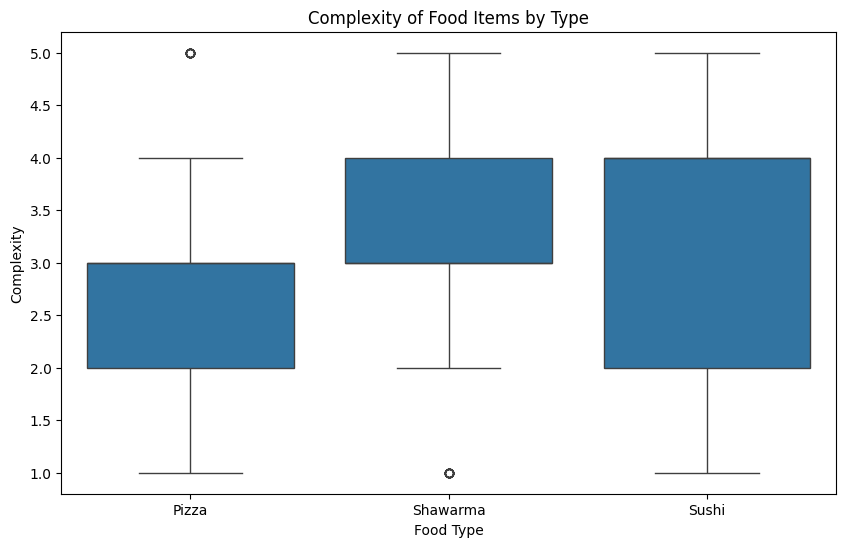

In [36]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label', y='1. complexity', data=data_exploration)
plt.title('Complexity of Food Items by Type')
plt.xlabel('Food Type')
plt.ylabel('Complexity')
plt.show()

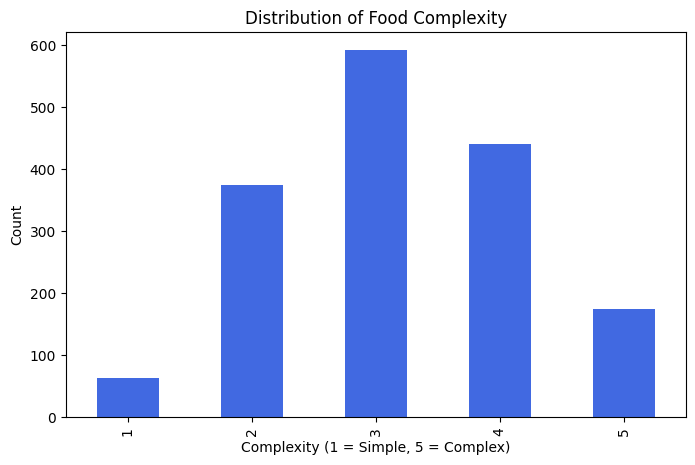

In [37]:
plt.figure(figsize=(8, 5))
data_exploration["1. complexity"].value_counts().sort_index().plot(kind="bar", color="royalblue")
plt.xlabel("Complexity (1 = Simple, 5 = Complex)")
plt.ylabel("Count")
plt.title("Distribution of Food Complexity")
plt.show()

## Q2: Ingredient Count

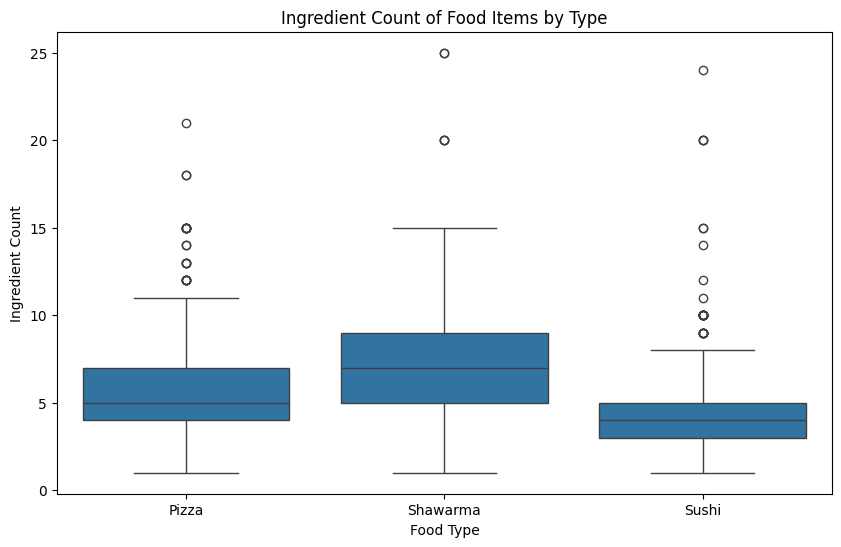

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label', y='2. ingredient count', data=data_exploration)
plt.title('Ingredient Count of Food Items by Type')
plt.xlabel('Food Type')
plt.ylabel('Ingredient Count')
plt.show()

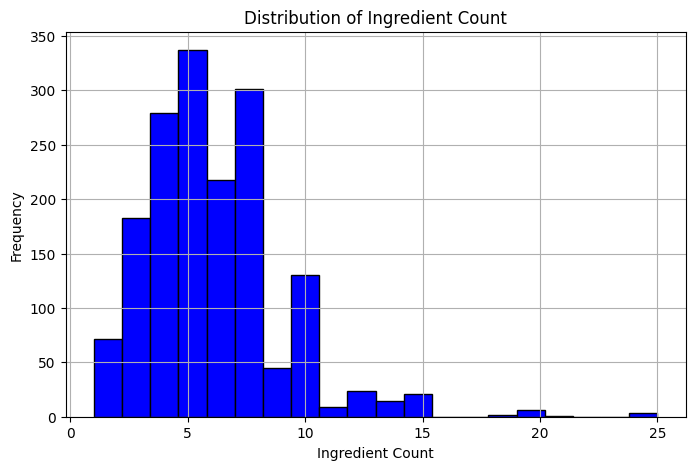

In [39]:
plt.figure(figsize=(8, 5))
data_exploration["2. ingredient count"].hist(bins=20, color="blue", edgecolor="black")
plt.xlabel("Ingredient Count")
plt.ylabel("Frequency")
plt.title("Distribution of Ingredient Count")
plt.show()

## Q3: Setting

In [40]:
def generate_food_type_counts(df):
    movies = ["Week day lunch", "Week day dinner", "Weekend lunch", "Weekend dinner", "At a party", "Late night snack"]
    food_type_counts = {}

    for food_type in df['Label'].unique():
        food_type_counts[food_type] = {}
        food_subset = df[df['Label'] == food_type]
        for setting in movies:
            food_type_counts[food_type][setting] = food_subset[setting].sum()

    return pd.DataFrame(food_type_counts).T



def generate_food_type_percentages(df):
    movies = ["Week day lunch", "Week day dinner", "Weekend lunch", "Weekend dinner", "At a party", "Late night snack"]
    food_type_counts = {}

    for food_type in df['Label'].unique():
        food_type_counts[food_type] = {}
        food_subset = df[df['Label'] == food_type]

        total = food_subset[movies].sum().sum()

        for setting in movies:
            count = food_subset[setting].sum()
            food_type_counts[food_type][setting] = round((count / total * 100) if total > 0 else 0, 2)

    return pd.DataFrame(food_type_counts).T

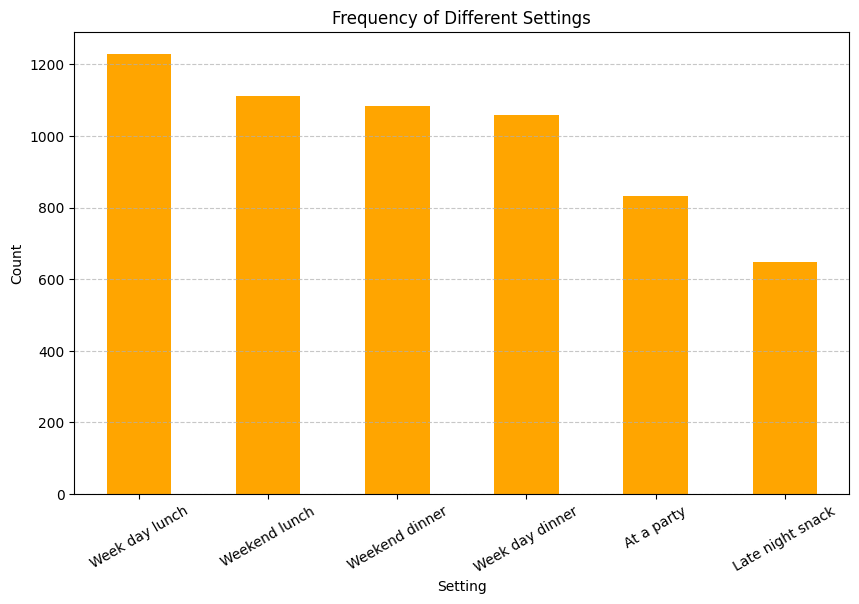

In [41]:
setting_cols = [
        "Week day lunch", "Week day dinner", "Weekend lunch",
        "Weekend dinner", "At a party", "Late night snack"
    ]
setting_counts = data_exploration[setting_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
setting_counts.plot(kind="bar", color="orange")
plt.xlabel("Setting")
plt.ylabel("Count")
plt.title("Frequency of Different Settings")
plt.xticks(rotation=30)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [42]:
def plot_setting_vs_label(df, label_col="Label"):
    """
    Creates a grouped bar chart showing how often each Q3 setting
    is chosen for each food label.

    Assumes Q3 is multi-hot encoded with columns like:
        "Week day lunch", "Week day dinner", "Weekend lunch",
        "Weekend dinner", "At a party", "Late night snack"
    """
    # Identify the setting columns for Q3
    setting_cols = [
        "Week day lunch", "Week day dinner", "Weekend lunch",
        "Weekend dinner", "At a party", "Late night snack"
    ]

    # 'Melt' the DataFrame so each (row, setting) combination is its own record
    melted = df.melt(
        id_vars=[label_col],
        value_vars=setting_cols,
        var_name="SettingCategory",
        value_name="Selected"
    )

    # Keep only rows where the setting was actually selected (1)
    melted = melted[melted["Selected"] == 1]

    # Group by (food label, setting category) to count how often each combo appears
    setting_counts = (
        melted.groupby([label_col, "SettingCategory"])
        .size()
        .reset_index(name="Count")
    )

    # Create the grouped bar chart
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=setting_counts,
        x=label_col,
        y="Count",
        hue="SettingCategory"
    )
    plt.title("Q3: Settings by Food Label")
    plt.xlabel("Food Label")
    plt.ylabel("Count")
    plt.legend(title="Setting Category", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

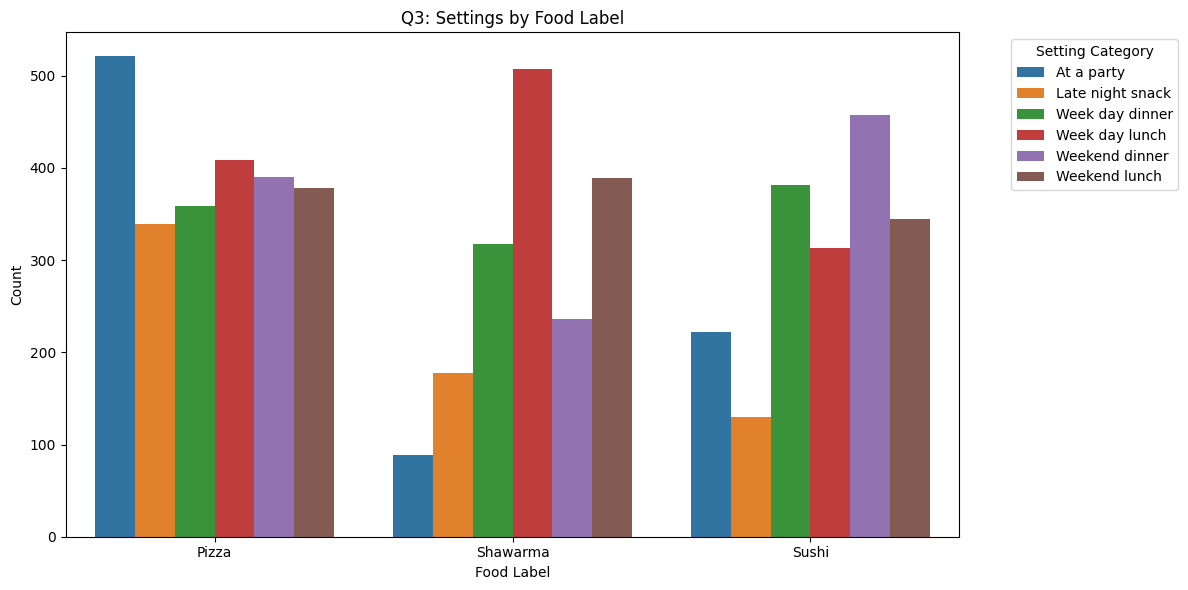

In [43]:
plot_setting_vs_label(data_exploration)

## Q4: Price

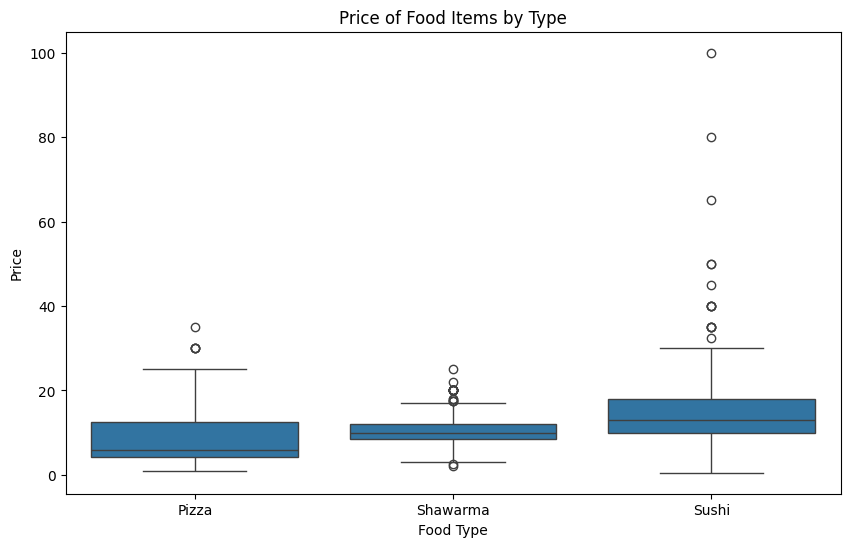

In [44]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label', y='4. price', data=data_exploration)
plt.title('Price of Food Items by Type')
plt.xlabel('Food Type')
plt.ylabel('Price')
plt.show()

Text(0.5, 1.0, 'Distribution of Food Price')

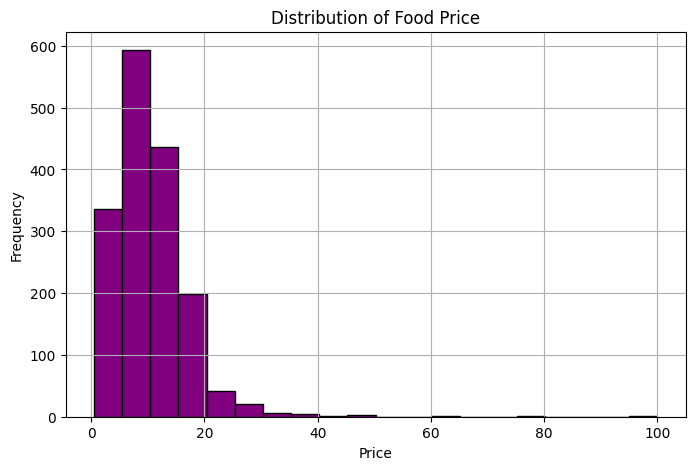

In [45]:
plt.figure(figsize=(8, 5))
data_exploration["4. price"].hist(bins=20, color="purple", edgecolor="black")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Distribution of Food Price")

## Q5: Movies

In [46]:
def generate_food_type_movie_counts(df):
    movies = ["movie_aladdin",
              "movie_avengers",
              "movie_cloudy with a chance of meatballs",
              "movie_finding nemo",
              "movie_home alone",
              "movie_jiro dreams of sushi",
              "movie_kill bill",
              "movie_kung fu panda",
              "movie_nan",
              "movie_no movie",
              "movie_none",
              "movie_other",
              "movie_ratatouille",
              "movie_rush hour",
              "movie_spiderman",
              "movie_spirited away",
              "movie_teenage mutant ninja turtles",
              "movie_the avengers",
              "movie_the dictator",
              "movie_your name"]

    movie_counts = {}

    for food_type in df['Label'].unique():
        movie_counts[food_type] = {}
        food_subset = df[df['Label'] == food_type]
        for movie in movies:
            movie_counts[food_type][movie] = food_subset[movie].sum()

    return pd.DataFrame(movie_counts).T


def generate_food_type_movie_percentages(df):
    movies = ["movie_aladdin",
              "movie_avengers",
              "movie_cloudy with a chance of meatballs",
              "movie_finding nemo",
              "movie_home alone",
              "movie_jiro dreams of sushi",
              "movie_kill bill",
              "movie_kung fu panda",
              "movie_nan",
              "movie_no movie",
              "movie_none",
              "movie_other",
              "movie_ratatouille",
              "movie_rush hour",
              "movie_spiderman",
              "movie_spirited away",
              "movie_teenage mutant ninja turtles",
              "movie_the avengers",
              "movie_the dictator",
              "movie_your name"]

    movie_percentages = {}

    for food_type in df['Label'].unique():
        movie_percentages[food_type] = {}
        food_subset = df[df['Label'] == food_type]

        total = food_subset[movies].sum().sum()

        for movie in movies:
            count = food_subset[movie].sum()
            movie_percentages[food_type][movie] = round((count / total * 100) if total > 0 else 0, 2)

    return pd.DataFrame(movie_percentages).T
# generate_food_type_movie_percentages(data_exploration)

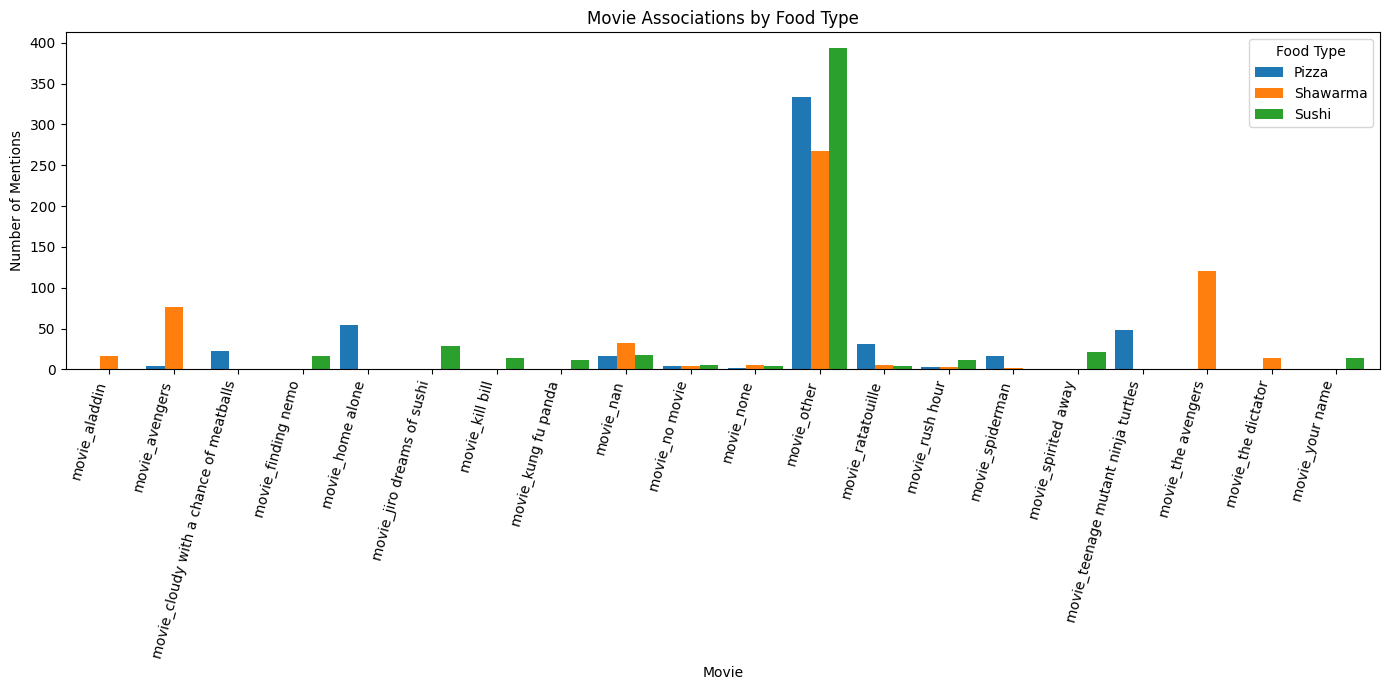

In [47]:
movie_counts_df = generate_food_type_movie_counts(data_exploration)

ax = movie_counts_df.T.plot(kind='bar', figsize=(14, 7), width=0.85)

plt.title("Movie Associations by Food Type")
plt.xlabel("Movie")
plt.ylabel("Number of Mentions")
plt.xticks(rotation=75, ha='right')
plt.legend(title="Food Type")
plt.tight_layout()
plt.show()

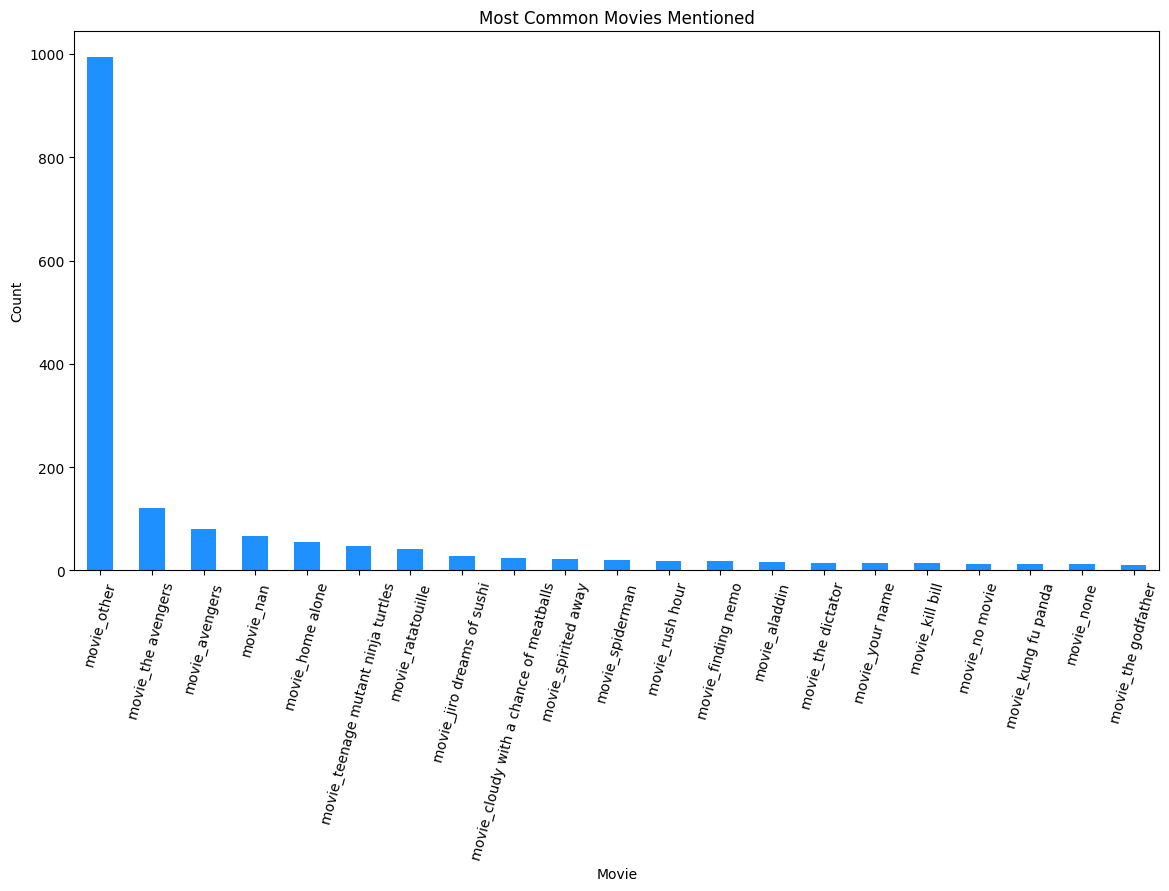

In [48]:
movie_cols = [col for col in data_exploration.columns if col.startswith("movie_")]
movie_counts = data_exploration[movie_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(14, 7))
movie_counts.plot(kind="bar", color="dodgerblue")
plt.xlabel("Movie")
plt.ylabel("Count")
plt.title("Most Common Movies Mentioned")
plt.xticks(rotation=75)
plt.show()

## Q6: Drink

In [49]:
def generate_food_type_drink_counts(df):
    drinks = [
        "drink_water",
        "drink_soft_drink",
        "drink_juice",
        "drink_tea",
        "drink_coffee",
        "drink_milk",
        "drink_alcoholic",
        "drink_fermented",
        "drink_other"
    ]

    drink_counts = {}

    for food_type in df['Label'].unique():
        drink_counts[food_type] = {}
        food_subset = df[df['Label'] == food_type]

        for drink in drinks:
            drink_counts[food_type][drink] = food_subset[drink].sum()

    return pd.DataFrame(drink_counts).T



def generate_food_type_drink_percentages(df):
    drinks = [
        "drink_water",
        "drink_soft_drink",
        "drink_juice",
        "drink_tea",
        "drink_coffee",
        "drink_milk",
        "drink_alcoholic",
        "drink_fermented",
        "drink_other"
    ]

    drink_percentages = {}

    for food_type in df['Label'].unique():
        drink_percentages[food_type] = {}
        food_subset = df[df['Label'] == food_type]

        total = food_subset[drinks].sum().sum()

        for drink in drinks:
            count = food_subset[drink].sum()
            drink_percentages[food_type][drink] = round((count / total * 100) if total > 0 else 0, 2)

    return pd.DataFrame(drink_percentages).T

generate_food_type_drink_counts(data_exploration)
# generate_food_type_drink_percentages(data_exploration)

drink_water  drink_soft_drink  drink_juice  drink_tea  drink_coffee  \
Pizza              44               461           12         22             0   
Shawarma          144               270           44         48             2   
Sushi             207                38            8        182             0   

          drink_milk  drink_alcoholic  drink_fermented  drink_other  
Pizza              5               12                1           12  
Shawarma           4                8               15           41  
Sushi              9               78                2           57

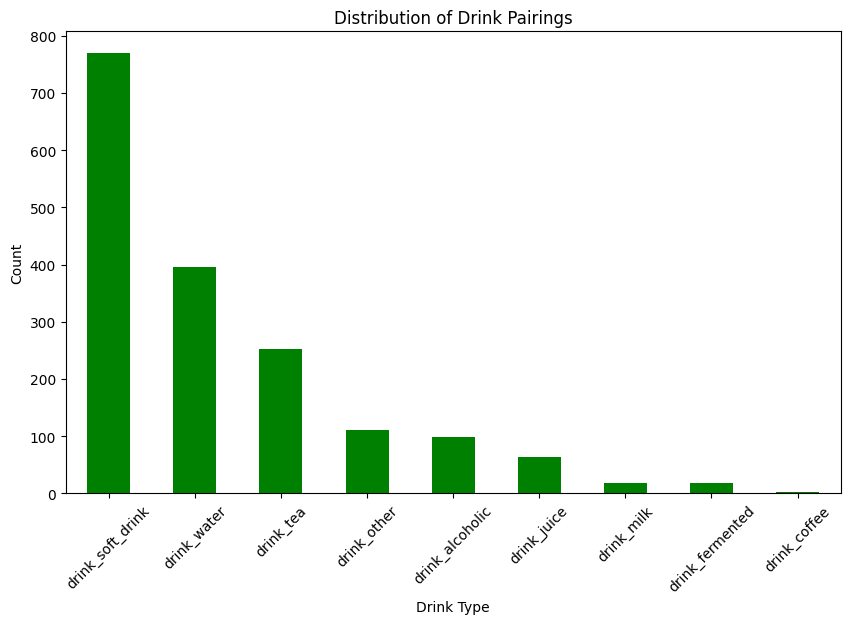

In [50]:
drink_cols = [col for col in data_exploration.columns if col.startswith("drink_")]
drink_counts = data_exploration[drink_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
drink_counts.plot(kind="bar", color="green")
plt.xlabel("Drink Type")
plt.ylabel("Count")
plt.title("Distribution of Drink Pairings")
plt.xticks(rotation=45)
plt.show()

In [51]:
def plot_drink_vs_label(df, label_col="Label"):
    """
    Creates a grouped bar chart showing how often each drink type is chosen for each label (food type).
    Assumes Q6 is multi-hot encoded into columns like 'drink_soft_drink', 'drink_water', etc.
    """
    # Identify the drink columns
    drink_cols = [c for c in df.columns if c.startswith("drink_")]

    # Melt the DataFrame so that each (row, drink_category) pair appears on its own
    # This way, if a single response had multiple drinks, we get multiple rows.
    melted = df.melt(
        id_vars=[label_col],
        value_vars=drink_cols,
        var_name="DrinkCategory",
        value_name="Selected"
    )

    # Filter down to only selected drinks
    melted = melted[melted["Selected"] == 1]

    # Now we have a table where each row is (food_label, drink_category).
    # Let's count how often each (food_label, drink_category) pair occurs.
    drink_counts = melted.groupby([label_col, "DrinkCategory"]).size().reset_index(name="Count")

    # Create the grouped bar chart
    plt.figure(figsize=(12, 6))
    sns.barplot(data=drink_counts, x=label_col, y="Count", hue="DrinkCategory")
    plt.title("Drink Categories by Food Label")
    plt.xlabel("Food Label")
    plt.ylabel("Count")
    plt.legend(title="Drink Category", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

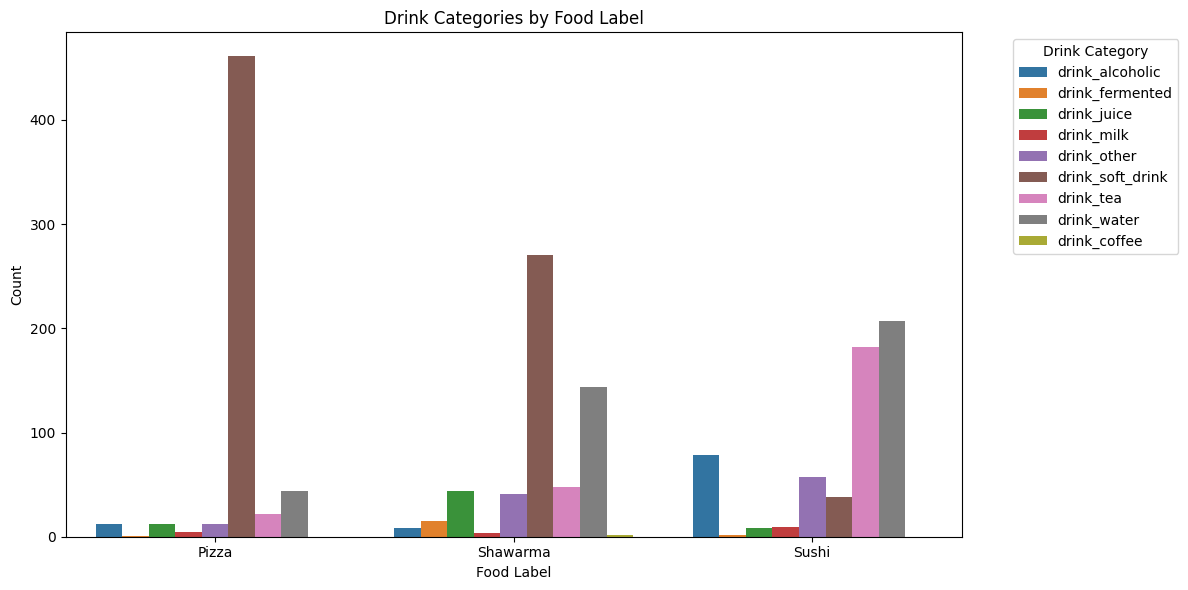

In [52]:
plot_drink_vs_label(data_exploration)

## Q7: Remind

In [53]:
def generate_food_type_reminder_counts(df):
    reminders = [
        "remind_parents",
        "remind_siblings",
        "remind_friends",
        "remind_teachers",
        "remind_strangers"
    ]

    reminder_counts = {}

    for food_type in df['Label'].unique():
        reminder_counts[food_type] = {}
        food_subset = df[df['Label'] == food_type]

        for reminder in reminders:
            reminder_counts[food_type][reminder] = food_subset[reminder].sum()

    return pd.DataFrame(reminder_counts).T


def generate_food_type_reminder_percentages(df):
    reminders = [
        "remind_parents",
        "remind_siblings",
        "remind_friends",
        "remind_teachers",
        "remind_strangers"
    ]

    reminder_percentages = {}

    for food_type in df['Label'].unique():
        reminder_percentages[food_type] = {}
        food_subset = df[df['Label'] == food_type]

        total = food_subset[reminders].sum().sum()

        for reminder in reminders:
            count = food_subset[reminder].sum()
            reminder_percentages[food_type][reminder] = round((count / total * 100) if total > 0 else 0, 2)

    return pd.DataFrame(reminder_percentages).T

generate_food_type_reminder_counts(data_exploration)
# generate_food_type_reminder_percentages(data_exploration)

remind_parents  remind_siblings  remind_friends  remind_teachers  \
Pizza                170              212             485              158   
Shawarma             138              142             382               25   
Sushi                280              211             387               29   

          remind_strangers  
Pizza                   89  
Shawarma               218  
Sushi                  127

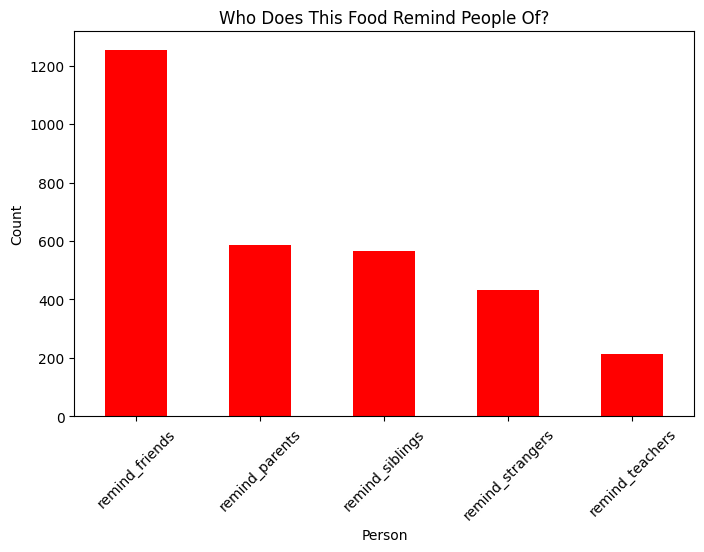

In [54]:
remind_cols = [col for col in data_exploration.columns if col.startswith("remind_")]
remind_counts = data_exploration[remind_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 5))
remind_counts.plot(kind="bar", color="red")
plt.xlabel("Person")
plt.ylabel("Count")
plt.title("Who Does This Food Remind People Of?")
plt.xticks(rotation=45)
plt.show()

In [55]:
def plot_remind_vs_label(df, label_col="Label"):
    """
    Creates a grouped bar chart showing how often each remind category
    (Q7: who does this food remind you of?) is chosen for each food label.

    Assumes Q7 is multi-hot encoded with columns like:
        remind_friends, remind_parents, remind_siblings, remind_strangers, remind_teachers
    """
    # Identify the remind columns
    remind_cols = [c for c in df.columns if c.startswith("remind_")]

    # Melt the DataFrame into long format
    melted = df.melt(
        id_vars=[label_col],
        value_vars=remind_cols,
        var_name="RemindCategory",
        value_name="Selected"
    )

    # Only keep rows where the remind category was selected
    melted = melted[melted["Selected"] == 1]

    # Count how often each (food_label, remind_category) pair occurs
    remind_counts = (
        melted.groupby([label_col, "RemindCategory"])
        .size()
        .reset_index(name="Count")
    )

    # Create the grouped bar chart
    plt.figure(figsize=(12, 6))
    sns.barplot(data=remind_counts, x=label_col, y="Count", hue="RemindCategory")
    plt.title("Remind Categories by Food Label")
    plt.xlabel("Food Label")
    plt.ylabel("Count")
    plt.legend(title="Remind Category", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

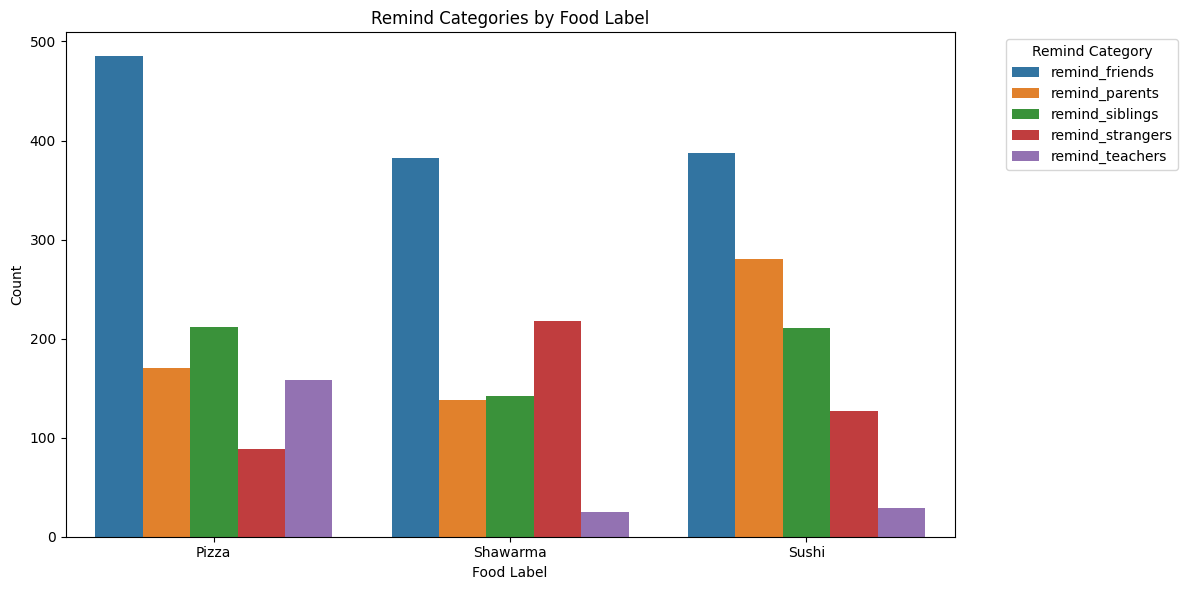

In [56]:
plot_remind_vs_label(data_exploration)

## Q8: Hot Sauce

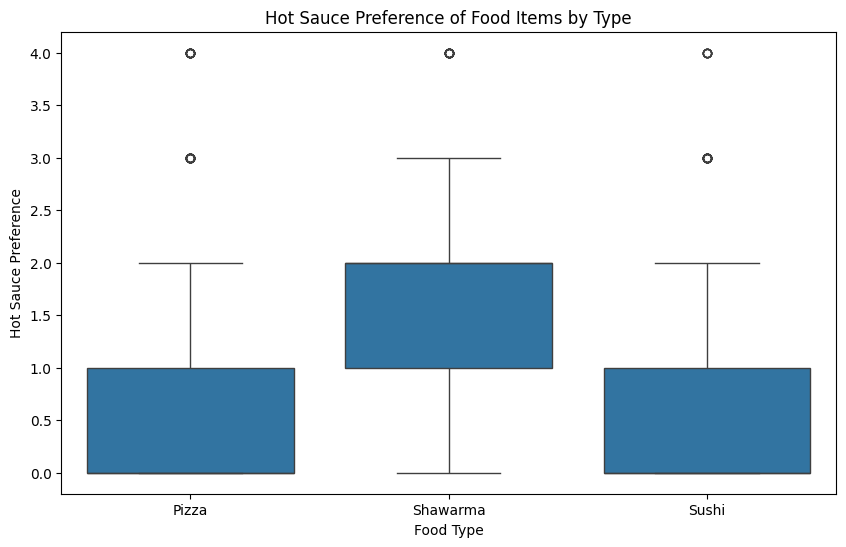

In [57]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label', y='8. hot sauce', data=data_exploration)
plt.title('Hot Sauce Preference of Food Items by Type')
plt.xlabel('Food Type')
plt.ylabel('Hot Sauce Preference')
plt.show()

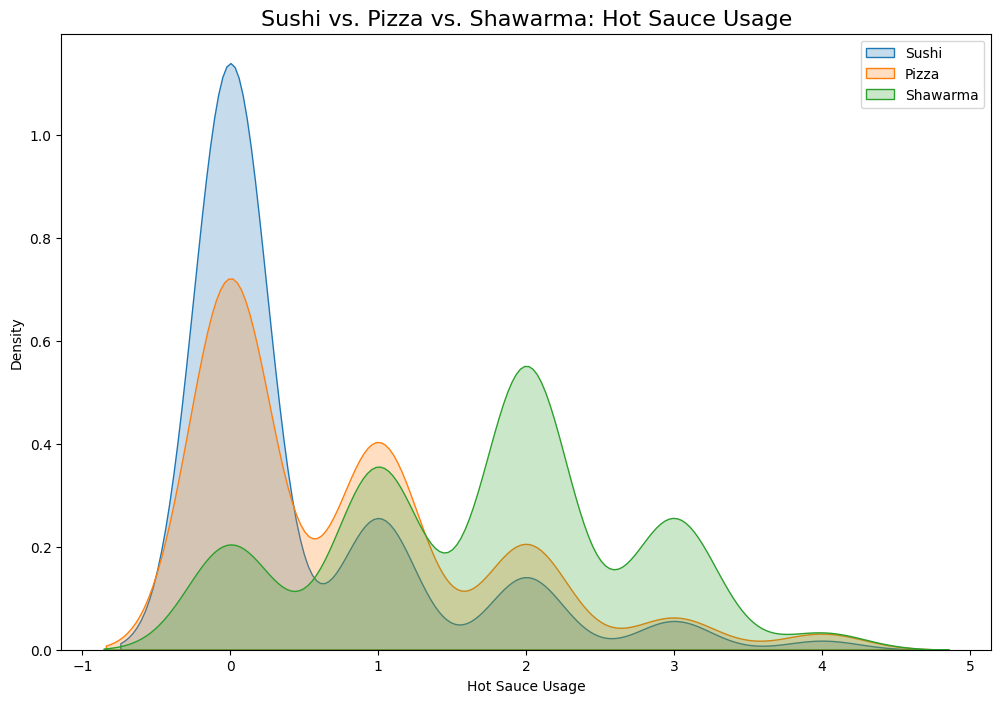

In [58]:
def plot_food_hot(df):
    sushi_data = df[df['Label'] == 'Sushi']
    pizza_data = df[df['Label'] == 'Pizza']
    schwarma_data = df[df['Label'] == 'Shawarma']

    feature = '8. hot sauce'

    plt.figure(figsize=(12, 8))
    plt.title('Sushi vs. Pizza vs. Shawarma: Hot Sauce Usage', fontsize=16)

    sns.kdeplot(sushi_data[feature].dropna(), label='Sushi', fill=True)
    sns.kdeplot(pizza_data[feature].dropna(), label='Pizza', fill=True)
    sns.kdeplot(schwarma_data[feature].dropna(), label='Shawarma', fill=True)

    plt.xlabel('Hot Sauce Usage')
    plt.ylabel('Density')
    plt.legend()
    plt.show()


plot_food_hot(data_exploration)


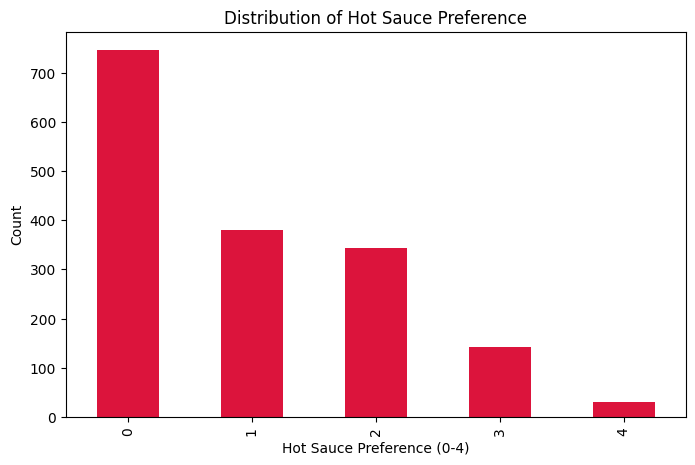

In [59]:
plt.figure(figsize=(8, 5))
data_exploration["8. hot sauce"].value_counts().sort_index().plot(kind="bar", color="crimson")
plt.xlabel("Hot Sauce Preference (0-4)")
plt.ylabel("Count")
plt.title("Distribution of Hot Sauce Preference")
plt.show()

# Splitting data



In [80]:
# def split_scale_encode(df: pd.DataFrame, label_col: str, scale_cols: list,
#                        test_frac: float = 0.2, val_frac: float = 0.15,
#                        random_state: int = 42):
#     """
#     Splits the DataFrame into training, validation, and test sets in a stratified manner,
#     scales specified numeric columns using StandardScaler (fitted on the training set),
#     and encodes the labels as integers while returning the label encoder.

#     Parameters:
#       df (pd.DataFrame): The full preprocessed DataFrame.
#       label_col (str): The name of the target column.
#       scale_cols (list): List of column names in X that should be scaled.
#       test_frac (float): Fraction of data to reserve as test set (default 0.2).
#       val_frac (float): Fraction of the full data to reserve as validation set (default 0.15).
#                         This fraction is applied to the data remaining after test split.
#       random_state (int): Seed for reproducibility.

#     Returns:
#       X_train (pd.DataFrame), y_train (pd.Series),
#       X_val (pd.DataFrame), y_val (pd.Series),
#       X_test (pd.DataFrame), y_test (pd.Series),
#       scaler (StandardScaler): The fitted scaler.
#       label_encoder (LabelEncoder): The fitted label encoder.
#     """
#     # 1. Separate features and labels.
#     X = df.drop(columns=[label_col])
#     y = df[label_col]

#     # 2. Encode labels as integers.
#     label_encoder = LabelEncoder()
#     y_encoded = label_encoder.fit_transform(y)
#     y = pd.Series(y_encoded, index=y.index)

#     # 3. Stratified split: first, split off the test set.
#     X_train_val, X_test, y_train_val, y_test = train_test_split(
#         X, y, test_size=test_frac, random_state=random_state, stratify=y, shuffle=True
#     )

#     # 4. Compute relative validation fraction from the remaining data.
#     relative_val_frac = val_frac / (1 - test_frac)

#     # 5. Stratified split for training and validation sets.
#     X_train, X_val, y_train, y_val = train_test_split(
#         X_train_val, y_train_val, test_size=relative_val_frac, random_state=random_state,
#         stratify=y_train_val, shuffle=True
#     )

#     # 6. Scale specified numeric columns in the training set.
#     scaler = StandardScaler()
#     X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])

#     # 7. Transform the validation and test sets using the fitted scaler.
#     X_val[scale_cols] = scaler.transform(X_val[scale_cols])
#     X_test[scale_cols] = scaler.transform(X_test[scale_cols])

#     # 8. Reset indices for cleanliness.
#     X_train.reset_index(drop=True, inplace=True)
#     X_val.reset_index(drop=True, inplace=True)
#     X_test.reset_index(drop=True, inplace=True)
#     y_train.reset_index(drop=True, inplace=True)
#     y_val.reset_index(drop=True, inplace=True)
#     y_test.reset_index(drop=True, inplace=True)

#     return X_train, y_train, X_val, y_val, X_test, y_test, scaler, label_encoder
import numpy as np
import pandas as pd

class BasicScaler:
    def __init__(self):
        self.means = None
        self.stds = None

    def fit(self, df: pd.DataFrame) -> "BasicScaler":
        # Compute means and standard deviations (ddof=0)
        self.means = df.mean()
        self.stds = df.std(ddof=0)
        return self

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        return (df - self.means) / self.stds

    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        self.fit(df)
        return self.transform(df)


# class BasicLabelEncoder:
#     def __init__(self):
#         self.classes_ = None
#         self.class_to_index = {}

#     def fit(self, y: pd.Series) -> "BasicLabelEncoder":
#         # Get unique classes in the order they appear
#         self.classes_ = list(pd.unique(y))
#         self.class_to_index = {cls: i for i, cls in enumerate(self.classes_)}
#         return self

#     def transform(self, y: pd.Series) -> pd.Series:
#         return y.map(self.class_to_index)

#     def fit_transform(self, y: pd.Series) -> pd.Series:
#         self.fit(y)
#         return self.transform(y)

from sklearn.model_selection import train_test_split  # if you prefer a custom stratified split, see below

def split_scale_encode(df: pd.DataFrame, label_col: str, scale_cols: list,
                       test_frac: float = 0.2, val_frac: float = 0.15,
                       random_state: int = 42):
    """
    Splits the DataFrame into training, validation, and test sets in a stratified manner,
    scales specified numeric columns using a custom BasicScaler (fitted on the training set),
    and encodes the labels as integers while returning the label encoder.

    Parameters:
      df (pd.DataFrame): The full preprocessed DataFrame.
      label_col (str): The name of the target column.
      scale_cols (list): List of column names in X that should be scaled.
      test_frac (float): Fraction of data to reserve as test set (default 0.2).
      val_frac (float): Fraction of the full data to reserve as validation set (default 0.15).
                        This fraction is applied to the data remaining after test split.
      random_state (int): Seed for reproducibility.

    Returns:
      X_train (pd.DataFrame), y_train (pd.Series),
      X_val (pd.DataFrame), y_val (pd.Series),
      X_test (pd.DataFrame), y_test (pd.Series),
      scaler (BasicScaler): The fitted scaler.
      label_encoder (BasicLabelEncoder): The fitted label encoder.
    """
    # Set seed for reproducibility.
    np.random.seed(random_state)

    # 1. Separate features and labels.
    X = df.drop(columns=[label_col]).copy()
    y = df[label_col].copy()

    # 2. Encode labels as integers using BasicLabelEncoder.
    label_encoder = BasicLabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y = pd.Series(y_encoded.values, index=y.index)

    # 3. Stratified split: first, split off the test set.
    # We'll do this using a basic approach (grouping by label):
    train_val_idx = []
    test_idx = []
    for label, group in y.groupby(y):
        indices = group.index.tolist()
        np.random.shuffle(indices)
        n_test = int(len(indices) * test_frac)
        test_idx.extend(indices[:n_test])
        train_val_idx.extend(indices[n_test:])

    X_train_val = X.loc[train_val_idx].copy()
    y_train_val = y.loc[train_val_idx].copy()
    X_test = X.loc[test_idx].copy()
    y_test = y.loc[test_idx].copy()

    # 4. Stratified split of train_val into train and validation.
    train_idx = []
    val_idx = []
    for label, group in y_train_val.groupby(y_train_val):
        indices = group.index.tolist()
        np.random.shuffle(indices)
        # Compute relative validation fraction from the remaining data.
        relative_val_frac = val_frac / (1 - test_frac)
        n_val = int(len(indices) * relative_val_frac)
        val_idx.extend(indices[:n_val])
        train_idx.extend(indices[n_val:])

    X_train = X_train_val.loc[train_idx].copy()
    y_train = y_train_val.loc[train_idx].copy()
    X_val = X_train_val.loc[val_idx].copy()
    y_val = y_train_val.loc[val_idx].copy()

    # 5. Scale specified numeric columns in the training set using BasicScaler.
    scaler = BasicScaler()
    X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])

    # 6. Transform the validation and test sets using the fitted scaler.
    X_val[scale_cols] = scaler.transform(X_val[scale_cols])
    X_test[scale_cols] = scaler.transform(X_test[scale_cols])

    # 7. Reset indices for cleanliness.
    X_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)

    return X_train, y_train, X_val, y_val, X_test, y_test, scaler, label_encoder


In [81]:
df_copy = df.copy()
df_copy = pre_process_pipeline(df_copy)
print(df_copy.columns)

X_train, y_train, X_val, y_val, X_test, y_test, scaler, label_encoder = split_scale_encode(
    df_copy,
    label_col='Label',
    scale_cols=['1. complexity', '2. ingredient count', '4. price', '8. hot sauce'])


# Confirm the shapes and class distribution
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)
print("Train class distribution:\n", pd.Series(y_train).value_counts(normalize=True))
print("Validation class distribution:\n", pd.Series(y_val).value_counts(normalize=True))
print("Test class distribution:\n", pd.Series(y_test).value_counts(normalize=True))

Index(['1. complexity', '2. ingredient count', '4. price', '8. hot sauce',
       'Label', 'Week day lunch', 'Week day dinner', 'Weekend lunch',
       'Weekend dinner', 'At a party', 'Late night snack', 'movie_aladdin',
       'movie_avengers', 'movie_cloudy with a chance of meatballs',
       'movie_finding nemo', 'movie_home alone', 'movie_jiro dreams of sushi',
       'movie_kill bill', 'movie_kung fu panda', 'movie_nan', 'movie_no movie',
       'movie_none', 'movie_other', 'movie_ratatouille', 'movie_rush hour',
       'movie_spiderman', 'movie_spirited away',
       'movie_teenage mutant ninja turtles', 'movie_the avengers',
       'movie_the dictator', 'movie_the godfather', 'movie_your name',
       'drink_water', 'drink_soft_drink', 'drink_juice', 'drink_tea',
       'drink_coffee', 'drink_milk', 'drink_alcoholic', 'drink_fermented',
       'drink_other', 'remind_parents', 'remind_siblings', 'remind_friends',
       'remind_teachers', 'remind_strangers'],
      dtype='object'

In [85]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split  # Using sklearn for stratified splitting

# -------------------------------
# Custom BasicLabelEncoder
# -------------------------------
class BasicLabelEncoder:
    def __init__(self):
        self.classes_ = None
        self.class_to_index = {}

    def fit(self, y: pd.Series):
        # Get unique classes in the order they appear
        self.classes_ = list(pd.unique(y))
        self.class_to_index = {cls: i for i, cls in enumerate(self.classes_)}
        return self

    def transform(self, y: pd.Series) -> pd.Series:
        return y.map(self.class_to_index)

    def fit_transform(self, y: pd.Series) -> pd.Series:
        self.fit(y)
        return self.transform(y)

    def inverse_transform(self, y: pd.Series) -> pd.Series:
        # Create an inverse mapping from index to class
        inv_map = {v: k for k, v in self.class_to_index.items()}
        return y.map(inv_map)

# -------------------------------
# Custom BasicScaler (if needed)
# -------------------------------
class BasicScaler:
    def __init__(self):
        self.means = None
        self.stds = None

    def fit(self, df: pd.DataFrame) -> "BasicScaler":
        self.means = df.mean()
        self.stds = df.std(ddof=0)
        return self

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        return (df - self.means) / self.stds

    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        self.fit(df)
        return self.transform(df)

# -------------------------------
# The split_scale_encode function
# -------------------------------
def split_scale_encode(df: pd.DataFrame, label_col: str, scale_cols: list,
                       test_frac: float = 0.2, val_frac: float = 0.15,
                       random_state: int = 42):
    """
    Splits the DataFrame into training, validation, and test sets in a stratified manner,
    scales specified numeric columns using BasicScaler (fitted on the training set),
    and encodes the labels as integers while returning the label encoder.

    Parameters:
      df (pd.DataFrame): The full preprocessed DataFrame.
      label_col (str): The name of the target column.
      scale_cols (list): List of column names to scale.
      test_frac (float): Fraction of data to reserve as test set.
      val_frac (float): Fraction of the full data to reserve as validation set.
      random_state (int): Seed for reproducibility.

    Returns:
      X_train, y_train, X_val, y_val, X_test, y_test, scaler, label_encoder
    """
    np.random.seed(random_state)

    # 1. Separate features and labels.
    X = df.drop(columns=[label_col]).copy()
    y = df[label_col].copy()

    # 2. Encode labels as integers.
    label_encoder = BasicLabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    y = pd.Series(y_encoded.values, index=y.index)

    # 3. Stratified split: first, split off the test set.
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_frac, random_state=random_state, stratify=y, shuffle=True
    )

    # 4. Compute relative validation fraction from remaining data.
    relative_val_frac = val_frac / (1 - test_frac)

    # 5. Stratified split for training and validation sets.
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=relative_val_frac, random_state=random_state,
        stratify=y_train_val, shuffle=True
    )

    # 6. Scale specified numeric columns in the training set.
    scaler = BasicScaler()
    X_train[scale_cols] = scaler.fit_transform(X_train[scale_cols])

    # 7. Transform the validation and test sets using the fitted scaler.
    X_val[scale_cols] = scaler.transform(X_val[scale_cols])
    X_test[scale_cols] = scaler.transform(X_test[scale_cols])

    # 8. Reset indices for cleanliness.
    X_train.reset_index(drop=True, inplace=True)
    X_val.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)

    return X_train, y_train, X_val, y_val, X_test, y_test, scaler, label_encoder

# -------------------------------
# Code to combine splits into CSV files with string labels
# -------------------------------
if __name__ == "__main__":
    # Load the full preprocessed DataFrame.

    # Specify the columns to scale.
    scale_columns = ["1. complexity", "2. ingredient count", "4. price", "8. hot sauce"]

    # Split, scale, and encode.
    X_train, y_train, X_val, y_val, X_test, y_test, scaler, label_encoder = split_scale_encode(
        data_exploration,
        label_col="Label",
        scale_cols=scale_columns,
        test_frac=0.2,
        val_frac=0.15,
        random_state=42
    )

    # Convert encoded labels back to their original string values.
    y_train_str = label_encoder.inverse_transform(y_train)
    y_val_str = label_encoder.inverse_transform(y_val)
    y_test_str = label_encoder.inverse_transform(y_test)

    # Combine features and labels into single DataFrames.
    df_train = pd.concat([X_train, y_train_str.rename("Label")], axis=1)
    df_val = pd.concat([X_val, y_val_str.rename("Label")], axis=1)
    df_test = pd.concat([X_test, y_test_str.rename("Label")], axis=1)

    # Save each split to its own CSV.
    df_train.to_csv("train.csv", index=False)
    df_val.to_csv("validation.csv", index=False)
    df_test.to_csv("test.csv", index=False)

    print("Train, validation, and test CSV files have been saved.")


Train, validation, and test CSV files have been saved.


In [83]:
df_copy_drop_movies = df.copy()
df_copy_drop_movies = pre_process_pipeline_drop_movies(df_copy_drop_movies)
print(df_copy_drop_movies.columns)

X_train2, y_train2, X_val2, y_val2, X_test2, y_test2, scaler2, label_encoder2 = split_scale_encode(
    df_copy_drop_movies,
    label_col='Label',
    scale_cols=['1. complexity', '2. ingredient count', '4. price', '8. hot sauce'])


# Confirm the shapes and class distribution
print("Train set shape:", X_train2.shape, y_train2.shape)
print("Validation set shape:", X_val2.shape, y_val2.shape)
print("Test set shape:", X_test2.shape, y_test2.shape)
print("Train class distribution:\n", pd.Series(y_train2).value_counts(normalize=True))
print("Validation class distribution:\n", pd.Series(y_val2).value_counts(normalize=True))
print("Test class distribution:\n", pd.Series(y_test2).value_counts(normalize=True))

Index(['1. complexity', '2. ingredient count', '4. price', '8. hot sauce',
       'Label', 'Week day lunch', 'Week day dinner', 'Weekend lunch',
       'Weekend dinner', 'At a party', 'Late night snack', 'drink_water',
       'drink_soft_drink', 'drink_juice', 'drink_tea', 'drink_coffee',
       'drink_milk', 'drink_alcoholic', 'drink_fermented', 'drink_other',
       'remind_parents', 'remind_siblings', 'remind_friends',
       'remind_teachers', 'remind_strangers'],
      dtype='object')
Train set shape: (1071, 24) (1071,)
Validation set shape: (246, 24) (246,)
Test set shape: (327, 24) (327,)
Train class distribution:
 0    0.333333
1    0.333333
2    0.333333
Name: proportion, dtype: float64
Validation class distribution:
 0    0.333333
1    0.333333
2    0.333333
Name: proportion, dtype: float64
Test class distribution:
 0    0.333333
1    0.333333
2    0.333333
Name: proportion, dtype: float64


# Model Exploration

## Rohan

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression(max_iter=1000, random_state = 42)
model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

Validation Accuracy: 0.8704453441295547
Test Accuracy: 0.851063829787234

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90        83
           1       0.83      0.87      0.85        82
           2       0.92      0.82      0.86        82

    accuracy                           0.87       247
   macro avg       0.87      0.87      0.87       247
weighted avg       0.87      0.87      0.87       247



In [ ]:
!pip install keras-tuner -q

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

def build_model(hp):
  model = Sequential()
  model.add(Input(shape=(X_train.shape[1],)))

  for i in range(hp.Int('num_layers', 1, 3)):
    units = hp.Choice(f'units_{i}', [32, 64, 128])
    activation = hp.Choice(f'activation_{i}', values=['relu', 'tanh'])
    model.add(Dense(units, activation=activation))
    if hp.Boolean(f'use_dropout_{i}', default=False):
      dropout_rate = hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)
      model.add(Dropout(dropout_rate))

  model.add(Dense(3, activation='softmax'))

  lr = hp.Float('learning_rate', 1e-4, 1e-2, sampling='LOG')
  model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  return model

tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=30,
    executions_per_trial=1,
    directory='bayes_tuning',
    project_name='mlp_bayes',
    seed=42
)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32)

best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hp.values)

best_model = tuner.hypermodel.build(best_hp)

X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])
history = best_model.fit(X_train_val, y_train_val, epochs=50, batch_size=32, validation_split=0.1)

test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print("Test Accuracy with tuned hyperparameters:", test_accuracy)




Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
2                 |2                 |num_layers
32                |32                |units_0
relu              |relu              |activation_0
False             |False             |use_dropout_0
0.0059777         |0.0059777         |learning_rate

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5395 - loss: 0.9243 - val_accuracy: 0.8259 - val_loss: 0.4706
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8469 - loss: 0.3809 - val_accuracy: 0.8583 - val_loss: 0.4254
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8867 - loss: 0.3269 - val_accuracy: 0.8583 - val_loss: 0.4165
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8853 - loss: 0.2971 - val_accuracy: 0.8907 - val_loss: 0.3641
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8934 - loss: 0.2809 - val_accuracy: 0.8664 - val_loss: 0.4032
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 

KeyboardInterrupt: 

In [ ]:
best_hp = {
    'num_layers': 1,
    'units_0': 128,
    'activation_0': 'relu',
    'use_dropout_0': False,
    'learning_rate': 0.0025124079357885637
}

def build_best_model(best_hp, input_shape, num_classes):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))

    # Use only as many layers as specified by 'num_layers'
    num_layers = best_hp['num_layers']
    for i in range(num_layers):
        units = best_hp[f'units_{i}']
        activation = best_hp[f'activation_{i}']
        model.add(Dense(units, activation=activation))
        if best_hp.get(f'use_dropout_{i}', False):
            dropout_rate = best_hp.get(f'dropout_rate_{i}', 0.0)
            model.add(Dropout(dropout_rate))

    # Output layer for multi-class classification (softmax over num_classes)
    model.add(Dense(num_classes, activation='softmax'))

    # Set the learning rate from hyperparameters
    lr = best_hp['learning_rate']
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

input_shape = X_train.shape[1]
num_classes = 3

model = build_best_model(best_hp, input_shape, num_classes)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

y_val_pred_probs = model.predict(X_val)
y_val_pred = y_val_pred_probs.argmax(axis=1)

y_test_pred_probs = model.predict(X_test)
y_test_pred = y_test_pred_probs.argmax(axis=1)

print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

print(classification_report(y_val, y_val_pred))

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.5554 - loss: 0.9620 - val_accuracy: 0.8219 - val_loss: 0.5222
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8216 - loss: 0.4766 - val_accuracy: 0.8704 - val_loss: 0.3807
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8851 - loss: 0.3585 - val_accuracy: 0.8785 - val_loss: 0.3707
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8847 - loss: 0.3216 - val_accuracy: 0.8785 - val_loss: 0.3590
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8922 - loss: 0.2926 - val_accuracy: 0.8785 - val_loss: 0.3538
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8999 - loss: 0.2744 - val_accuracy: 0.8826 - val_loss: 0.3347
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8984 - loss: 0.2831 - val_accuracy: 0.8826 - val_loss: 0.3478
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9269 - loss: 0.2213 - val_accuracy: 0.8826 - val_loss

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Validation Accuracy: 0.8866396761133604
Test Accuracy: 0.8389057750759878
              precision    recall  f1-score   support

           0       0.87      0.90      0.89        83
           1       0.89      0.91      0.90        82
           2       0.90      0.84      0.87        82

    accuracy                           0.89       247
   macro avg       0.89      0.89      0.89       247
weighted avg       0.89      0.89      0.89       247



## Hanli

In [73]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

rs = 42
# Define models in a dictionary
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=rs),
    "Decision Tree": DecisionTreeClassifier(random_state=rs),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=rs),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=rs),
    "SVM": SVC(random_state=rs),
    "KNeighbors": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=rs),
    "MLP": MLPClassifier(hidden_layer_sizes=(50,), max_iter=500, random_state=rs)
}

# Train each model and evaluate performance
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)

    print(f"{name} Validation Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(y_val, y_val_pred))
    print("-" * 50)


Training Logistic Regression...
Logistic Regression Validation Accuracy: 0.8333
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84        82
           1       0.88      0.74      0.81        82
           2       0.83      0.87      0.85        82

    accuracy                           0.83       246
   macro avg       0.84      0.83      0.83       246
weighted avg       0.84      0.83      0.83       246

--------------------------------------------------
Training Decision Tree...
Decision Tree Validation Accuracy: 0.7805
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.87      0.83        82
           1       0.80      0.68      0.74        82
           2       0.76      0.79      0.77        82

    accuracy                           0.78       246
   macro avg       0.78      0.78      0.78       246
weighted avg       0.78      0.78      0.78     

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:38:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Validation Accuracy: 0.8171
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85        82
           1       0.83      0.71      0.76        82
           2       0.81      0.87      0.84        82

    accuracy                           0.82       246
   macro avg       0.82      0.82      0.82       246
weighted avg       0.82      0.82      0.82       246

--------------------------------------------------
Training MLP...
MLP Validation Accuracy: 0.8089
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84        82
           1       0.80      0.77      0.78        82
           2       0.80      0.80      0.80        82

    accuracy                           0.81       246
   macro avg       0.81      0.81      0.81       246
weighted avg       0.81      0.81      0.81       246

--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 21.0 MB/s eta 0:00:00


In [78]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold


cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
def objective_xgb(trial):
    """
    Defines a hyperparameter search space for XGBoost and returns the average
    cross-validation accuracy.
    """
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300, step=10),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0, step=0.1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0, step=0.1),
        "gamma": trial.suggest_float("gamma", 0, 5, step=1),
        "eval_metric": "logloss",
        "random_state": 13
    }

    model = XGBClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")
    return scores.mean()

# Define the Objective Function for MLP
def objective_mlp(trial):
    """
    Defines a hyperparameter search space for MLPClassifier and returns the average
    cross-validation accuracy.
    """
    hidden_layer_size = trial.suggest_int("hidden_layer_size", 10, 200, step=10)

    alpha = trial.suggest_float("alpha", 1e-5, 1e-1, log=True)
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True)
    activation = trial.suggest_categorical("activation", ["tanh", "relu"])
    solver = trial.suggest_categorical("solver", ["adam", "sgd"])

    model = MLPClassifier(
        hidden_layer_sizes=(hidden_layer_size,),
        max_iter=500,
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        activation=activation,
        solver=solver,
        random_state=42
    )

    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")
    return scores.mean()

# Run Optuna Study for XGBoost
study_xgb = optuna.create_study(direction="maximize", study_name="XGBoost Optuna Tuning")
study_xgb.optimize(objective_xgb, n_trials=30, timeout=None)
print("Best trial for XGBoost:")
print(f" Value: {study_xgb.best_trial.value}")
print(f" Params: {study_xgb.best_trial.params}")

# Train final XGBoost model with best hyperparams:
best_params_xgb = study_xgb.best_trial.params
best_params_xgb.update({
    "use_label_encoder": False,
    "eval_metric": "logloss",
    "random_state": 42
})
final_xgb = XGBClassifier(**best_params_xgb)
final_xgb.fit(X_train, y_train)
y_val_pred_xgb = final_xgb.predict(X_val)
xgb_accuracy = accuracy_score(y_val, y_val_pred_xgb)

print("\n-- Final XGBoost Model --")
print(f"Validation Accuracy: {xgb_accuracy:.4f}")
print(classification_report(y_val, y_val_pred_xgb))

# Run Optuna Study for MLP
study_mlp = optuna.create_study(direction="maximize", study_name="MLP Optuna Tuning")
study_mlp.optimize(objective_mlp, n_trials=30, timeout=None)
print("\nBest trial for MLP:")
print(f" Value: {study_mlp.best_trial.value}")
print(f" Params: {study_mlp.best_trial.params}")

# Train final MLP model with best hyperparams:
best_params_mlp = study_mlp.best_trial.params
final_mlp = MLPClassifier(
    hidden_layer_sizes=(best_params_mlp["hidden_layer_size"],),
    max_iter=500,
    alpha=best_params_mlp["alpha"],
    learning_rate_init=best_params_mlp["learning_rate_init"],
    activation=best_params_mlp["activation"],
    solver=best_params_mlp["solver"],
    random_state=42
)
final_mlp.fit(X_train, y_train)
y_val_pred_mlp = final_mlp.predict(X_val)
mlp_accuracy = accuracy_score(y_val, y_val_pred_mlp)

print("\n-- Final MLP Model --")
print(f"Validation Accuracy: {mlp_accuracy:.4f}")
print(classification_report(y_val, y_val_pred_mlp))

[I 2025-03-29 04:40:09,867] A new study created in memory with name: XGBoost Optuna Tuning
[I 2025-03-29 04:40:10,470] Trial 0 finished with value: 0.8590102707749767 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.031727941926056914, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 3.0}. Best is trial 0 with value: 0.8590102707749767.
[I 2025-03-29 04:40:11,159] Trial 1 finished with value: 0.8468720821661998 and parameters: {'n_estimators': 120, 'max_depth': 8, 'learning_rate': 0.002632144281201596, 'subsample': 1.0, 'colsample_bytree': 0.6, 'gamma': 4.0}. Best is trial 0 with value: 0.8590102707749767.
[I 2025-03-29 04:40:14,086] Trial 2 finished with value: 0.8468720821661998 and parameters: {'n_estimators': 180, 'max_depth': 7, 'learning_rate': 0.0024514567579023445, 'subsample': 0.7, 'colsample_bytree': 0.9, 'gamma': 0.0}. Best is trial 0 with value: 0.8590102707749767.
[I 2025-03-29 04:40:14,729] Trial 3 finished with value: 0.8468720821661998 and par

Best trial for XGBoost:
 Value: 0.8674136321195145
 Params: {'n_estimators': 210, 'max_depth': 9, 'learning_rate': 0.08944686810497533, 'subsample': 0.9, 'colsample_bytree': 0.7, 'gamma': 1.0}

-- Final XGBoost Model --
Validation Accuracy: 0.8455
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        82
           1       0.85      0.77      0.81        82
           2       0.83      0.87      0.85        82

    accuracy                           0.85       246
   macro avg       0.85      0.85      0.84       246
weighted avg       0.85      0.85      0.84       246



[I 2025-03-29 04:40:32,332] Trial 0 finished with value: 0.8478057889822596 and parameters: {'hidden_layer_size': 130, 'alpha': 0.007549596582961807, 'learning_rate_init': 0.02801292549145705, 'activation': 'tanh', 'solver': 'adam'}. Best is trial 0 with value: 0.8478057889822596.
[I 2025-03-29 04:40:33,475] Trial 1 finished with value: 0.8450046685340803 and parameters: {'hidden_layer_size': 80, 'alpha': 0.00014573669451055238, 'learning_rate_init': 0.013363750057575412, 'activation': 'relu', 'solver': 'adam'}. Best is trial 0 with value: 0.8478057889822596.
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converge


Best trial for MLP:
 Value: 0.869281045751634
 Params: {'hidden_layer_size': 190, 'alpha': 0.00829782966474484, 'learning_rate_init': 0.010200110606794457, 'activation': 'tanh', 'solver': 'sgd'}

-- Final MLP Model --
Validation Accuracy: 0.8455
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        82
           1       0.84      0.79      0.82        82
           2       0.85      0.84      0.85        82

    accuracy                           0.85       246
   macro avg       0.85      0.85      0.84       246
weighted avg       0.85      0.85      0.84       246



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [86]:
best_params_mlp = {
    "hidden_layer_sizes": (190,),
    "alpha": 0.00829782966474484,
    "learning_rate_init": 0.010200110606794457,
    "activation": "tanh",
    "solver": "sgd",
    "max_iter": 500,
    "random_state": 42
}

final_mlp = MLPClassifier(**best_params_mlp)

final_mlp.fit(X_train, y_train)

y_val_pred = final_mlp.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
y_test_pred = final_mlp.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

Validation Accuracy: 0.8906882591093117
Test Accuracy: 0.8632218844984803

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91        83
           1       0.86      0.91      0.89        82
           2       0.91      0.84      0.87        82

    accuracy                           0.89       247
   macro avg       0.89      0.89      0.89       247
weighted avg       0.89      0.89      0.89       247



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
best_params_mlp = {
    "hidden_layer_sizes": (120,),
    "alpha": 0.022794022713833025,
    "learning_rate_init": 0.010609828889300572,
    "activation": "tanh",
    "solver": "sgd",
    "max_iter": 500,
    "random_state": 42
}

final_mlp = MLPClassifier(**best_params_mlp)

final_mlp.fit(X_train2, y_train2)

y_val_pred = final_mlp.predict(X_val2)
val_accuracy = accuracy_score(y_val2, y_val_pred)
y_test_pred = final_mlp.predict(X_test2)
test_accuracy = accuracy_score(y_test2, y_test_pred)

print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)
print("\nClassification Report:\n", classification_report(y_val2, y_val_pred))

Validation Accuracy: 0.854251012145749
Test Accuracy: 0.8389057750759878

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.90      0.89        83
           1       0.79      0.89      0.84        82
           2       0.91      0.77      0.83        82

    accuracy                           0.85       247
   macro avg       0.86      0.85      0.85       247
weighted avg       0.86      0.85      0.85       247



/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
weights = final_mlp.coefs_
biases = final_mlp.intercepts_
print("Weights:", weights)
print("Biases:", biases)

Weights: [array([[-0.03162932,  0.18801711,  0.02344649, ..., -0.09646355,
         0.27471925, -0.00864902],
       [ 0.10163417,  0.2343496 , -0.04437819, ..., -0.26182819,
         0.22081217, -0.12088866],
       [ 0.13500644,  0.15718806,  0.19154984, ...,  0.0652724 ,
         0.0218234 , -0.07596702],
       ...,
       [ 0.10111894,  0.06169913, -0.10087489, ...,  0.07736215,
         0.04175537, -0.02181698],
       [ 0.04274299, -0.20197289, -0.05316094, ..., -0.0694121 ,
         0.15761923, -0.04424938],
       [ 0.17302326,  0.02902401, -0.13484996, ..., -0.02545566,
         0.00097749,  0.17799919]]), array([[ 9.05255065e-02,  3.24380260e-02,  1.12031998e-01],
       [-1.07441209e-01,  4.38382198e-02, -1.37903137e-01],
       [-5.23274687e-02, -1.50895980e-01,  5.81316761e-02],
       [ 5.51216673e-02,  6.00702115e-02, -3.37729943e-01],
       [-9.58772548e-03,  7.23326928e-01, -6.50574094e-01],
       [-2.93707673e-01, -3.68858454e-01,  5.05486915e-01],
       [ 3.67347

## Vincent

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# MULTILAYER PERCEPTRON
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)
mlp_model.fit(X_train_scaled, y_train)

y_val_pred = mlp_model.predict(X_val_scaled)
print("MLP Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

## Richard
random forest
XGboost
logistic regression

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

Validation Accuracy: 0.8704453441295547
Test Accuracy: 0.8419452887537994

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90        83
           1       0.84      0.90      0.87        82
           2       0.88      0.80      0.84        82

    accuracy                           0.87       247
   macro avg       0.87      0.87      0.87       247
weighted avg       0.87      0.87      0.87       247



In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=300, learning_rate=0.1, use_label_encoder=False, eval_metric="mlogloss", random_state=43)
model.fit(X_train, y_train)

y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:36:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Accuracy: 0.8906882591093117
Test Accuracy: 0.8480243161094225

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.91        83
           1       0.85      0.94      0.89        82
           2       0.91      0.83      0.87        82

    accuracy                           0.89       247
   macro avg       0.89      0.89      0.89       247
weighted avg       0.89      0.89      0.89       247



In [ ]:
!pip install scikit-optimize -q

from xgboost import XGBClassifier
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Define the model with some fixed parameters
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=43)

# Define the hyperparameter search space.
# Note: You can specify ranges and distributions for each parameter.
param_space = {
    'n_estimators': (100, 500),  # Integer range
    'learning_rate': (0.01, 0.2, 'log-uniform'),  # Log-uniform sampling for learning rate
    'max_depth': (3, 10),  # Integer range
    'subsample': (0.5, 1.0, 'uniform'),  # Uniform distribution between 0.5 and 1.0
    'colsample_bytree': (0.5, 1.0, 'uniform'),
    'gamma': (0, 0.5, 'uniform'),
    'reg_alpha': (0, 1.0, 'uniform'),
    'reg_lambda': (0.5, 2.0, 'uniform'),
}

# Set up the Bayesian optimization using BayesSearchCV.
# n_iter specifies how many hyperparameter combinations to try.
opt = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=param_space,
    n_iter=30,  # Try 30 different hyperparameter combinations
    cv=3,
    scoring='accuracy',
    random_state=43,
    verbose=1
)

# Fit the optimizer on the training data.
opt.fit(X_train, y_train)

# Output the best hyperparameters.
print("Best parameters:", opt.best_params_)

# Predict on the validation set using the best model.
y_val_pred = opt.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.2 MB/s eta 0:00:00
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:37:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:37:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:37:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:37:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:37:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:37:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:37:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:37:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:37:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:37:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:37:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:37:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:37:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


KeyboardInterrupt: 